Using device: cpu

--- Training SimpleCNN ---
Epoch [1/10], Train Loss: 217.3728, Val Loss: 5.2848
Epoch [2/10], Train Loss: 14.2874, Val Loss: 5.3443
Epoch [3/10], Train Loss: 7.1636, Val Loss: 4.7513
Epoch [4/10], Train Loss: 5.4689, Val Loss: 4.9684
Epoch [5/10], Train Loss: 7.1910, Val Loss: 4.5071
Epoch [6/10], Train Loss: 5.5892, Val Loss: 4.2305
Epoch [7/10], Train Loss: 5.5889, Val Loss: 4.1817
Epoch [8/10], Train Loss: 5.6689, Val Loss: 4.3189
Epoch [9/10], Train Loss: 5.9183, Val Loss: 5.2924
Epoch [10/10], Train Loss: 5.3763, Val Loss: 3.7912
--- SimpleCNN training finished. Duration: 6.12 seconds ---

--- Evaluation Metrics for SimpleCNN ---
Test Loss (MSE): 44.7704
Mean Squared Error (MSE): 4.7792
Root Mean Squared Error (RMSE): 2.1861
Mean Absolute Error (MAE): 1.7921
R-squared (R2): 0.8166

--- Training UNet ---
Epoch [1/10], Train Loss: 1225028.1732, Val Loss: 459.4051
Epoch [2/10], Train Loss: 852.7027, Val Loss: 441.8353
Epoch [3/10], Train Loss: 459.0270, Val Loss: 3

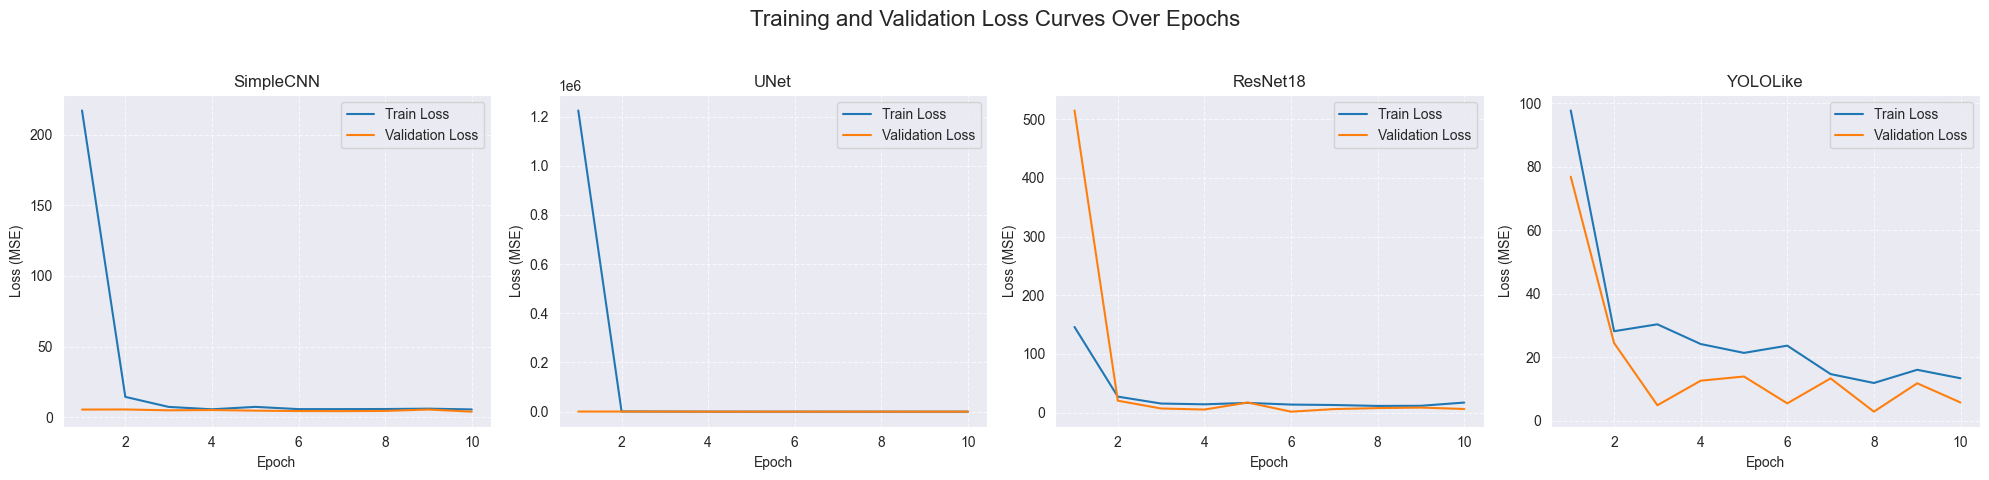


--- Evaluation Metrics for SimpleCNN ---
Test Loss (MSE): 44.7704
Mean Squared Error (MSE): 4.7792
Root Mean Squared Error (RMSE): 2.1861
Mean Absolute Error (MAE): 1.7921
R-squared (R2): 0.8166

--- Evaluation Metrics for UNet ---
Test Loss (MSE): 46.0565
Mean Squared Error (MSE): 7.0161
Root Mean Squared Error (RMSE): 2.6488
Mean Absolute Error (MAE): 2.0326
R-squared (R2): 0.7308

--- Evaluation Metrics for ResNet18 ---
Test Loss (MSE): 51.9749
Mean Squared Error (MSE): 8.0047
Root Mean Squared Error (RMSE): 2.8293
Mean Absolute Error (MAE): 2.2596
R-squared (R2): 0.6929

--- Evaluation Metrics for YOLOLike ---
Test Loss (MSE): 47.0564
Mean Squared Error (MSE): 6.7750
Root Mean Squared Error (RMSE): 2.6029
Mean Absolute Error (MAE): 2.0151
R-squared (R2): 0.7401


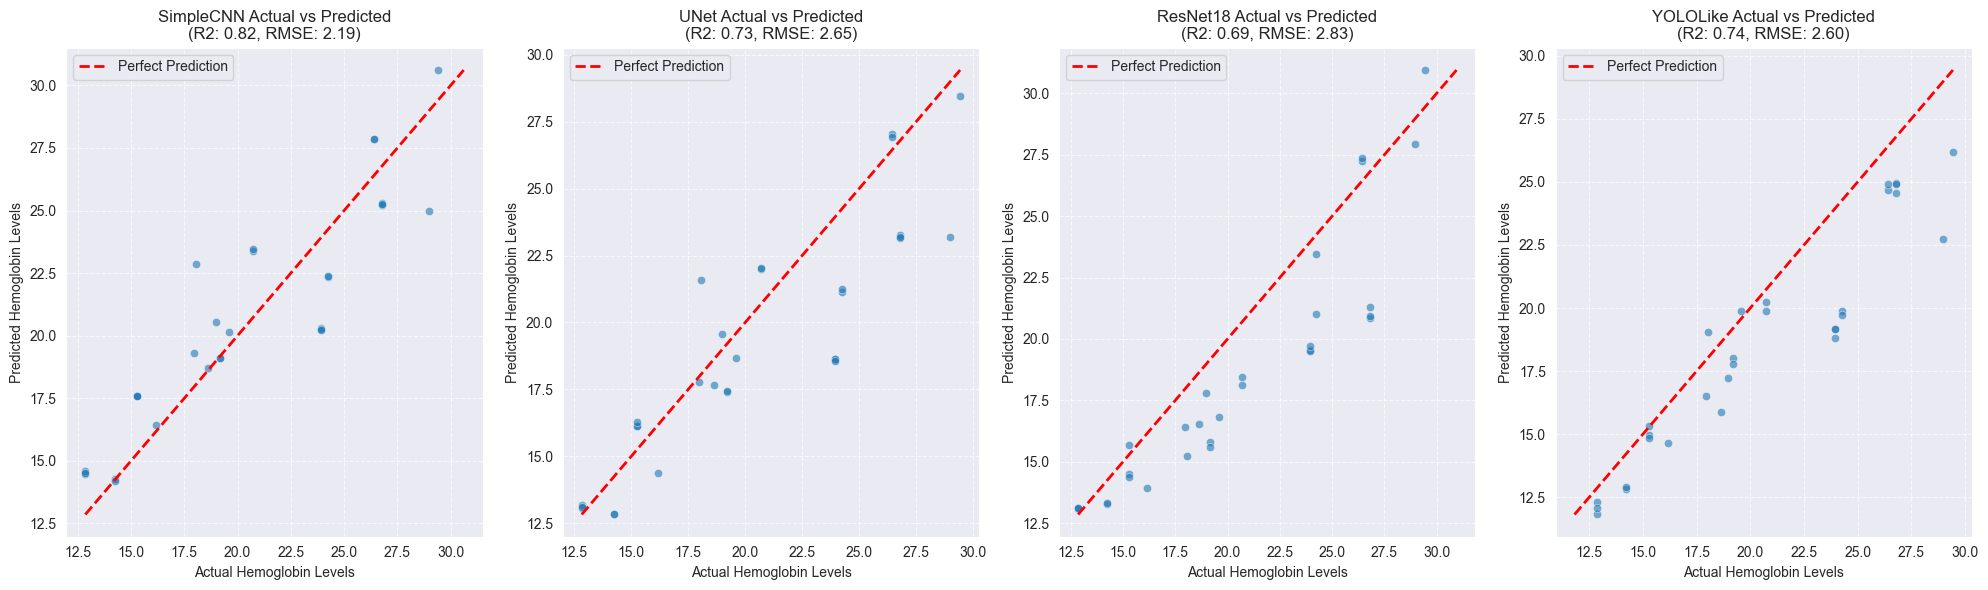


--- Final Model Performance Summary ---
          Training Time (s) Final Train Loss (MSE) Final Val Loss (MSE)  \
Model                                                                     
SimpleCNN              6.12                 5.3763               3.7912   
UNet                 117.53                 6.2481               6.2417   
ResNet18              24.66                17.1114               6.1368   
YOLOLike               8.88                13.3409               5.7042   

          Test Loss (MSE)    RMSE     MAE      R2  
Model                                              
SimpleCNN         44.7704  2.1861  1.7921  0.8166  
UNet              46.0565  2.6488  2.0326  0.7308  
ResNet18          51.9749  2.8293  2.2596  0.6929  
YOLOLike          47.0564  2.6029  2.0151  0.7401  


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights # Import for ResNet18 weights
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
import time # Import the time module
import warnings
warnings.filterwarnings("ignore")

# --- 0. Configuration and Seed Setting ---
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.406]) # Standard ImageNet normalization
])

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Dataset and DataLoader Definition ---

class HemoglobinImageDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# --- 2. Model Definitions ---

# 2.1 Simple CNN Model
class SimpleCNNPredictor(nn.Module):
    def __init__(self):
        super(SimpleCNNPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2.2 U-Net Model for Regression
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match the size of x2 if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNetHemoglobinPredictor(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNetHemoglobinPredictor, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        # Regression head after U-Net output
        self.flatten = nn.Flatten()
        # Calculate the size after OutConv: n_classes * H_out * W_out
        # For 64x64 input, the U-Net typically outputs a map of the same size.
        # So it would be n_classes * 64 * 64
        self.fc_regress = nn.Sequential(
            nn.Linear(n_classes * 64 * 64, 256), # Output size of U-Net is 1x64x64 if n_classes=1
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x) # Output is now n_classes x H x W

        x = self.flatten(x) # Flatten to 1D vector
        x = self.fc_regress(x) # Pass through regression head
        return x

# 2.3 ResNet Model for Regression
class ResNetHemoglobinPredictor(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ResNetHemoglobinPredictor, self).__init__()

        # Updated way to load pretrained weights
        if pretrained:
            self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT) # Use .DEFAULT for latest recommended weights
        else:
            self.resnet = models.resnet18(weights=None) # No pretrained weights

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 新增：2.4 YOLO 风格的骨干 + 回归头部模型
class YOLOLikeHemoglobinPredictor(nn.Module):
    def __init__(self):
        super(YOLOLikeHemoglobinPredictor, self).__init__()
        # 骨干网络 (YOLO 风格的更深层卷积)
        # 使用步长为2的卷积代替池化进行下采样
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # 64x64 -> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x32 -> 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            # 可以根据需要添加更多层，以增加深度和特征提取能力
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 8x8 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )

        # 估算 backbone 输出的特征图尺寸
        # 64x64 经过 stride=2 的三次卷积，尺寸变为 64/2/2/2 = 8x8
        # 输出通道为 256
        # 所以展平后的尺寸是 256 * 8 * 8 = 16384

        # 回归头部
        self.reg_head = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256), # 全连接层1
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3), # 添加 Dropout 防止过拟合
            nn.Linear(256, 128), # 全连接层2
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1) # 输出层，预测一个回归值
        )

    def forward(self, x):
        """
        定义前向传播过程
        :param x: 输入张量
        :return: 输出张量
        """
        x = self.backbone(x)  # 通过骨干网络提取特征
        x = x.view(x.size(0), -1)  # 展平特征图
        x = self.reg_head(x)  # 通过回归头部得到预测值
        return x

# --- 3. Training and Evaluation Functions ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    model.to(device)
    print(f"\n--- Training {model_name} ---")

    train_losses = []
    val_losses = []
    start_time = time.time()

    best_val_loss = float('inf')
    # No EarlyStopping class here, implementing simple early stopping logic
    # with a counter. You can re-introduce the EarlyStopping class if preferred.
    patience = 10
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Simple Early Stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Optional: Save best model state
            # torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping for {model_name} at epoch {epoch+1} due to no improvement in validation loss.")
                break


    end_time = time.time()
    training_duration = end_time - start_time
    print(f"--- {model_name} training finished. Duration: {training_duration:.2f} seconds ---")

    return train_losses, val_losses, training_duration


def evaluate_model(model, test_loader, model_name):
    model.eval()
    predictions = []
    all_labels = []

    test_loss = 0.0
    criterion = nn.MSELoss() # Re-instantiate criterion for test loss calculation

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move to device for loss calculation
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predictions.extend(outputs.cpu().numpy().ravel())
            all_labels.extend(labels.cpu().numpy().ravel())

    avg_test_loss = test_loss / len(test_loader)

    predictions = np.array(predictions)
    all_labels = np.array(all_labels)

    mse = mean_squared_error(all_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_labels, predictions)
    r2 = r2_score(all_labels, predictions)

    print(f'\n--- Evaluation Metrics for {model_name} ---')
    print(f'Test Loss (MSE): {avg_test_loss:.4f}') # Display test loss
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R2): {r2:.4f}')

    return predictions, all_labels, {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'test_loss': avg_test_loss}

# --- 4. Main Execution Flow ---

if __name__ == "__main__":
    # Read data
    data = pd.read_csv('./train/血红蛋白浓度值.csv')

    # Create dataset instance
    full_dataset = HemoglobinImageDataset(
        data=data,
        image_dir='./train/processed_images',
        transform=transform
    )

    # Split into training, validation, and test sets (70% / 15% / 15%)
    total_size = len(full_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Ensure sizes add up correctly (due to int casting)
    if train_size + val_size + test_size != total_size:
        test_size = total_size - train_size - val_size

    # Check for extremely small splits for debugging/handling
    if train_size <= 0 or val_size <= 0 or test_size <= 0:
        print("Warning: One or more dataset splits are too small (<= 0). Adjusting split strategy.")
        # Fallback to a simpler 80/20 train/test split if the dataset is tiny
        if total_size >= 2: # Need at least 2 samples for split
            train_size = int(0.8 * total_size)
            test_size = total_size - train_size
            val_size = 0 # No explicit validation set in this fallback
            print(f"Using a fallback 80/20 train/test split: Train={train_size}, Test={test_size}")
        else:
            print("Error: Dataset has too few samples to perform any split. Please add more data.")
            exit() # Exit if no meaningful split can be made

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define models to compare (新增 YOLOLikeHemoglobinPredictor)
    models_to_compare = {
        "SimpleCNN": SimpleCNNPredictor(),
        "UNet": UNetHemoglobinPredictor(n_channels=3, n_classes=1),
        "ResNet18": ResNetHemoglobinPredictor(num_classes=1, pretrained=True),
        "YOLOLike": YOLOLikeHemoglobinPredictor() # 新增模型
    }

    results_summary = [] # To store final metrics for DataFrame
    all_loss_histories = {} # To store training and validation loss histories

    num_epochs = 10

    for model_name, model in models_to_compare.items():
        set_seed(SEED) # Reset seed for consistent model initialization

        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        # Train model and get loss histories and duration
        # 注意：这里我们移除了对早停类的直接调用，而是将早停逻辑集成到train_model函数内部。
        # 如果你希望使用专门的EarlyStopping类，需要将其重新添加到train_model中。
        train_losses, val_losses, training_duration = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name
        )
        all_loss_histories[model_name] = {'train_loss': train_losses, 'val_loss': val_losses}

        # Evaluate model
        predictions, actual_labels, metrics = evaluate_model(model, test_loader, model_name)

        # Add training duration and specific losses to metrics for summary
        metrics['training_duration_s'] = training_duration
        metrics['final_train_loss'] = train_losses[-1] # Last epoch's train loss
        metrics['final_val_loss'] = val_losses[-1]   # Last epoch's val loss

        results_summary.append({
            'Model': model_name,
            'Training Time (s)': f"{training_duration:.2f}",
            'Final Train Loss (MSE)': f"{metrics['final_train_loss']:.4f}",
            'Final Val Loss (MSE)': f"{metrics['final_val_loss']:.4f}",
            'Test Loss (MSE)': f"{metrics['test_loss']:.4f}", # test loss from the evaluate function
            'RMSE': f"{metrics['rmse']:.4f}",
            'MAE': f"{metrics['mae']:.4f}",
            'R2': f"{metrics['r2']:.4f}"
        })

    # --- 5. Statistical Comparison (DataFrame) ---
    comparison_df = pd.DataFrame(results_summary)
    print("\n--- Model Performance Comparison ---")
    print(comparison_df.set_index('Model'))

    # --- 6. Visualization ---

    # 6.1 Training and Validation Loss Curves
    plt.figure(figsize=(20, 5)) # Adjust figure size for 4 plots
    plt.suptitle('Training and Validation Loss Curves Over Epochs', fontsize=16)

    for i, (model_name, loss_history) in enumerate(all_loss_histories.items()):
        plt.subplot(1, len(models_to_compare), i + 1)
        plt.plot(range(1, len(loss_history['train_loss']) + 1), loss_history['train_loss'], label='Train Loss')
        plt.plot(range(1, len(loss_history['val_loss']) + 1), loss_history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # 6.2 Actual vs Predicted Scatter Plots
    plt.figure(figsize=(20, 6)) # Adjust figure size for 4 plots

    plot_idx = 1
    # Iterate through model names and corresponding instantiated models
    for model_name, model_instance in models_to_compare.items():
        # Re-evaluate for plotting data (ensure it uses the trained model instance)
        predictions, actual_labels, metrics = evaluate_model(model_instance, test_loader, model_name)

        plt.subplot(1, len(models_to_compare), plot_idx)
        sns.scatterplot(x=actual_labels, y=predictions, alpha=0.6)
        plt.xlabel('Actual Hemoglobin Levels')
        plt.ylabel('Predicted Hemoglobin Levels')
        plt.title(f'{model_name} Actual vs Predicted\n(R2: {metrics["r2"]:.2f}, RMSE: {metrics["rmse"]:.2f})')

        # Plot diagonal line
        min_val = min(min(actual_labels), min(predictions))
        max_val = max(max(actual_labels), max(predictions))
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plot_idx += 1

    plt.tight_layout()
    plt.show()

    # --- 7. Final Summary DataFrame Output ---
    # This will print the dataframe at the very end as requested.
    print("\n--- Final Model Performance Summary ---")
    print(pd.DataFrame(results_summary).set_index('Model'))